# Project: Property Rentals

### 📖 Background
You have been hired by Inn the Neighborhood, an online platform that allows people to rent out their properties for short stays. Currently, the webpage for renters has a conversion rate of 2%. This means that most people leave the platform without signing up.

The product manager would like to increase this conversion rate. They are interested in developing an application to help people estimate the money they could earn renting out their living space. They hope that this would make people more likely to sign up.

The company has provided you with a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.

### Table of Content

1. **Getting to know the dataset**  <br>
    1.1 Distributions & Descriptive Statistics <br>
    1.2 Missing Values <br>
    1.3 Quick Fixes <br>
    1.4 Summary <br>
2. **Exploratory Data Analysis & Cleaning**<br>
    2.1 How we started <br>
    2.2 Price <br>
    2.3 Minimum nights <br>
    2.4 Bathrooms <br>
    2.5 Bedrooms <br> 
    2.6 Summary
3. **Feature Selection** 
4. **Model Selection** 
5. **Final Recommendation**

In [2]:
# import essential packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy.stats import skew
import matplotlib.pyplot as plt

import drop
import utils
from utils.visualize import viz
from utils.stats import outliers
from utils.models import quick_test, predict

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from pandas.plotting import scatter_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5)

ModuleNotFoundError: No module named 'housing'

## First insights

### 1.1 Distributions & Descriptive Statistics 

Before building any models and suggesting new strategies, we should investigate the dataset thoroughly. The first part will consist of a simple skim over the values to get a sense of the data. We will investigate the distributions, skewness magnitude, and the missing values situation. 

In [3]:
# load the dataset & check out the data
rentals = pd.read_csv('data/rentals.csv')
rentals.head(3)

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00


In [4]:
# look into descriptive statistics
rentals.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights
count,8.111000e+03,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03
mean,2.024561e+07,37.766054,-122.430107,1.395975,1.345874,1.234526e+04
std,1.228565e+07,0.022937,0.026967,0.923213,0.925298,1.110357e+06
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08


In [5]:
# check the missing values 
print(f'Dataset shape: {rentals.shape}')
print(f'Number of missing values: {int(rentals.isna().sum(axis=0).sum())}')

Dataset shape: (8111, 9)
Number of missing values: 16


In [6]:
# show where the values are missing 
rentals.isna().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

In [7]:
rentals[rentals.isnull().any(axis=1)]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
139,144978,37.79336,-122.42506,Apartment,Private room,NaN,1.0,30,$56.00
181,229240,37.79341,-122.40340,Hostel,Shared room,NaN,1.0,1,$45.00
196,259621,37.79470,-122.40374,Hostel,Shared room,NaN,1.0,1,$45.00
197,259622,37.79441,-122.40473,Hostel,Shared room,NaN,1.0,1,$45.00
267,430692,37.75906,-122.40761,Apartment,Private room,NaN,1.0,31,$68.00
269,431862,37.78321,-122.41969,Apartment,Entire home/apt,1.0,NaN,30,$124.00
352,596042,37.79384,-122.42436,Apartment,Private room,NaN,1.0,30,$63.00
434,785901,37.79313,-122.40443,Hostel,Shared room,NaN,1.0,1,$45.00
435,786492,37.79421,-122.40310,Hostel,Shared room,NaN,1.0,1,$45.00
436,786506,37.79260,-122.40339,Hostel,Shared room,NaN,1.0,1,$45.00


In [8]:
# check the tails presence
print('Kurtosis score:')
rentals.kurtosis()

Kurtosis score:


id                  -1.261659
latitude            -0.525995
longitude            0.619062
bathrooms           29.631055
bedrooms             6.658742
minimum_nights    8110.999990
dtype: float64

#### Kurtosis results
Kurtosis is used to calculate the magnitude of the tails. Here we see that there are extremely long tails in bathrooms, bedrooms, and minimum nights columns. Let's show them visually to verify the anomalies. Indeed, all of these columns will need to be carefully analyzed. 

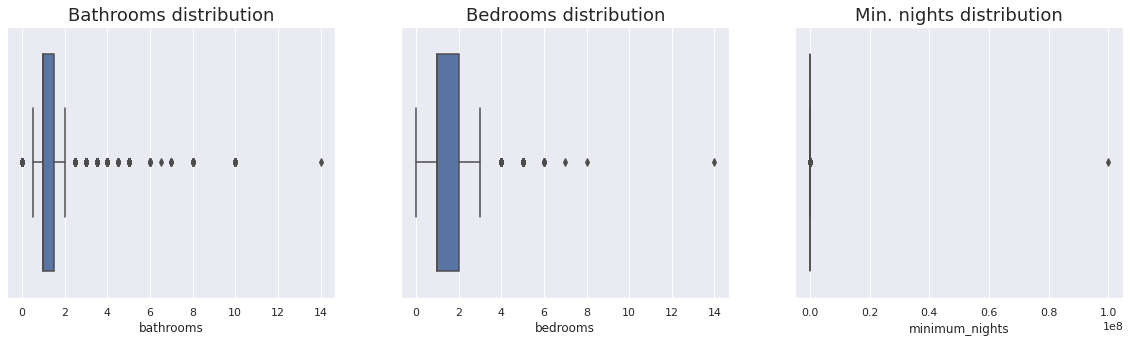

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(rentals['bathrooms'], ax=ax[0]).set_title('Bathrooms distribution', fontsize=18)
sns.boxplot(rentals['bedrooms'], ax=ax[1]).set_title('Bedrooms distribution', fontsize=18)
sns.boxplot(rentals['minimum_nights'], ax=ax[2]).set_title('Min. nights distribution', fontsize=18)
plt.show()

### 1.2 Missing Values

Even though it's a common practice to impute the missing values with a mean, I have some doubts about using this method. Since we are working with discrete values rather than continuous, it is worth to check the data beforehand. Let's do exactly that!

In [10]:
print(f'Mean bathrooms: {rentals["bathrooms"].mean()}')
print(f'Median bathrooms: {rentals["bathrooms"].median()}')

print('\n===\n')

print(f'Mean bedrooms: {rentals["bedrooms"].mean()}')
print(f'Median bedrooms: {rentals["bedrooms"].median()}')

Mean bathrooms: 1.3959748117051487
Median bathrooms: 1.0

===

Mean bedrooms: 1.345873936104601
Median bedrooms: 1.0


From what we see above, indeed, using median value is more appropriate since it doesn't create a floating number. One solution would be to use "floor" operator with mean, but a simpler solution is to stick with median values. 

In [11]:
# fill in the missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
rentals[['bathrooms', 'bedrooms']] = imp.fit_transform(rentals[['bathrooms', 'bedrooms']])

rentals.isna().sum()

id                0
latitude          0
longitude         0
property_type     0
room_type         0
bathrooms         0
bedrooms          0
minimum_nights    0
price             0
dtype: int64

### 1.3 Quick Fixes

Even though we have seen performed a small number of exploratory steps, we still can see a number of issues that need to be fixed beforehand. The following steps will be performed:

1. Change the "property_type" and "room_type" data types to category;
2. Drop the unnecessary "id" columns since it does not have any value;
3. Check the duplicate situation; drop them if present;
4. Alter the "price" column, convert it to numeric data type

In [12]:
# create a lambda function to apply type conversion
change_type = lambda x: x.astype('category')

rentals[['property_type', 'room_type']] = rentals[['property_type', 'room_type']].apply(change_type, axis=0)
rentals.dtypes

id                   int64
latitude           float64
longitude          float64
property_type     category
room_type         category
bathrooms          float64
bedrooms           float64
minimum_nights       int64
price               object
dtype: object

In [13]:
# check for duplicates
rentals[rentals.duplicated()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price


In [14]:
# drop id columns
rentals.drop('id', axis='columns', inplace=True)
assert 'id' not in rentals.columns.tolist(), 'ID is still in the dataset!'

In [15]:
# take care of the price column
rentals.price = rentals.price.apply(lambda x: x.replace('$', '').replace(',', '').strip()).astype('float64')
rentals.dtypes

latitude           float64
longitude          float64
property_type     category
room_type         category
bathrooms          float64
bedrooms           float64
minimum_nights       int64
price              float64
dtype: object

count     8111.000000
mean       225.407101
std        412.253039
min          0.000000
25%        100.000000
50%        150.000000
75%        240.000000
max      10000.000000
Name: price, dtype: float64

===

Kurtosis score: 347.5520892053762


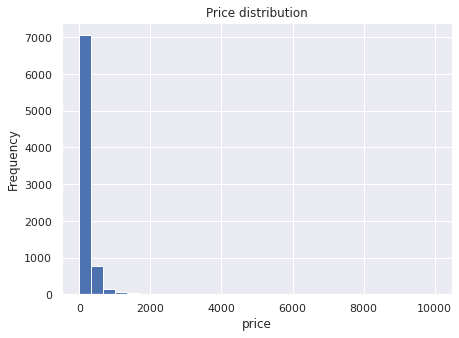

In [16]:
# verify changes 
print(rentals.price.describe())

print('\n===\n')

print('Kurtosis score:', rentals.price.kurtosis())

viz.hist(rentals, 'price')

### 1.5 Summary

Overall, the dataset doesn't have a lot of missing values which is great. However, it does have the following problems that need to be addressed:
- The kurtosis score is extreme for both features (bedrooms=6.7, bathrooms=29.6, and minimum nights=8111) and target (price=347.5); this shows the outlier situation. 
- Usually the bedroom/bathroom ratio is heavily correlated with the price. However, in our case, the highest correlation is 0.26 with bedrooms column, and 0.08 with bathrooms. 


I prefer an approach where each column gets treated properly. Thus, the next section is going to have a heavy data analysis. 



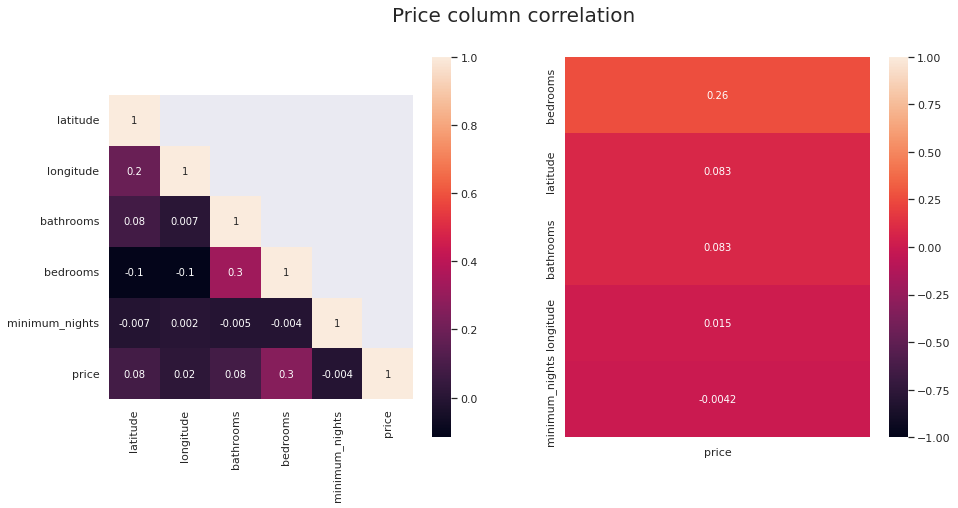

In [17]:
viz.corr_matrix(rentals)

## 2 **Closer look**: Feature Engineering, Preprocessing, Advanced Techniques 

### 2.1 How we started

The goal of this notebook is to predict so that there prices are not more than $25 above the predictions. First, let's build the simple OLS model to see the current state of it. Then, we will use the model to make our first predictions. It will give a better sense of the work that will need to be done. 

From what see below, the model's R2 (goodness of fit) is only 51.4% which is almost the same as the random guess. With such an accuracy, it won't be surprsing to see predictions off the chart as seen below. 

In [18]:
quick_test.build_ols(rentals)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     258.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:16:41   Log-Likelihood:                -5898.5
No. Observations:                8111   AIC:                         1.187e+04
Df Residuals:                    8077   BIC:                         1.210e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0852      0.006    912.728      0.0

In [19]:
predict.sample_predict(rentals, n=10)

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,predicted,difference (actual - predicted)
5772,37.77903,-122.41408,Apartment,Entire home/apt,1.0,1.0,30,156.0,166.563875,-10.563875
6565,37.73542,-122.43873,Guest suite,Entire home/apt,1.0,1.0,1,110.0,121.177974,-11.177974
4452,37.76135,-122.43027,Apartment,Entire home/apt,2.0,3.0,30,300.0,273.647591,26.352409
5917,37.75110,-122.40843,Apartment,Private room,1.0,1.0,1,150.0,80.019270,69.980730
2825,37.77672,-122.41628,Apartment,Private room,1.0,1.0,1,128.0,96.401708,31.598292
2522,37.77926,-122.44907,House,Entire home/apt,1.5,2.0,2,300.0,240.848920,59.151080
5212,37.78290,-122.39846,Apartment,Entire home/apt,1.0,0.0,30,127.0,124.006144,2.993856
5717,37.78088,-122.45590,Condominium,Entire home/apt,1.5,3.0,90,166.0,366.302813,-200.302813
4924,37.76505,-122.48008,House,Private room,1.0,1.0,1,130.0,87.509103,42.490897
4350,37.78584,-122.43297,Condominium,Entire home/apt,2.0,2.0,30,395.0,275.098600,119.901400


### 2.2 Distributions 


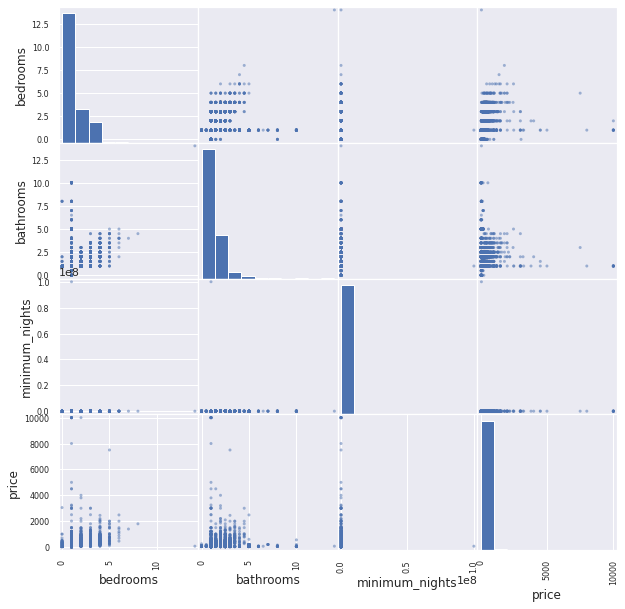

In [20]:
selected = rentals[['bedrooms', 'bathrooms', 'minimum_nights', 'price']]

scatter_matrix(selected, figsize = (10, 10))
plt.show()

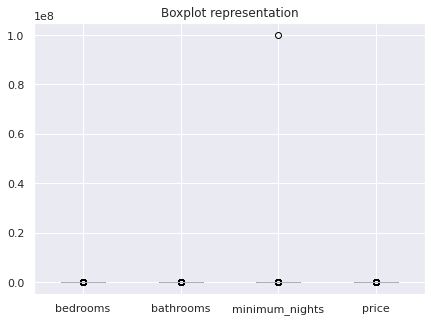

In [21]:
selected.boxplot().set_title('Boxplot representation')
plt.show()

### 2.3 Price

Since we have already cleaned the price columns and altered it to be a numeric column, let's now find the appropriate cutting point. 

In [22]:
# look into the distribution
rentals.price.describe()

count     8111.000000
mean       225.407101
std        412.253039
min          0.000000
25%        100.000000
50%        150.000000
75%        240.000000
max      10000.000000
Name: price, dtype: float64

In [23]:
# print the possible and definite outliers 
suspect, outlier = outliers.describe_outliers(rentals, 'price')

Price suspects (mean +- 1.5 * IQR) at: [-60.0, 360.0]
Number of suspects: 884

====

Price definite (mean +- 3.0 * IQR) outliers at: [-270.0, 570.0]
Number of outliers: 395


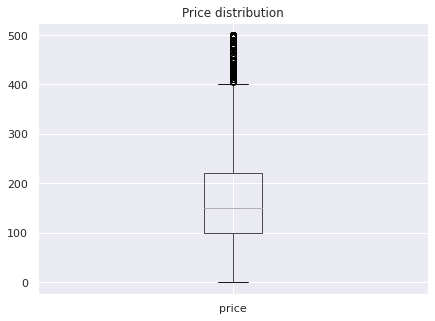

In [24]:
cleaned_df = rentals[rentals['price'] <= 500]

plt.figure(figsize=(7, 5))
cleaned_df[['price']].boxplot().set_title('Price distribution')
plt.show()

In [25]:
cleaned_df['price'].describe()

count    7659.000000
mean      170.930278
std        99.454526
min         0.000000
25%        99.000000
50%       150.000000
75%       220.000000
max       500.000000
Name: price, dtype: float64

#### Further steps
Now that we dropped all values less than $500, let's look into the following:
1. Remove the free-listings (where price == 0)
2. Print the number of dropped values 
3. Visualize the current price distribution

In [26]:
cleaned_df[cleaned_df['price'] == 0]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
3752,37.74479,-122.41977,Condominium,Private room,1.0,1.0,4,0.0


In [27]:
cleaned_df.drop(index=3752, inplace=True)
print(f'Current min price: ${cleaned_df["price"].min()}')

Current min price: $10.0


In [28]:
print(f'Before drop (min=$0, max=$10,000):     {len(rentals)} rows')
print(f'After drop (min=$10, max=$500):        {len(cleaned_df)} rows')
print(f'Dropped:                               {len(rentals) - len(cleaned_df)} rows')

Before drop (min=$0, max=$10,000):     8111 rows
After drop (min=$10, max=$500):        7658 rows
Dropped:                               453 rows


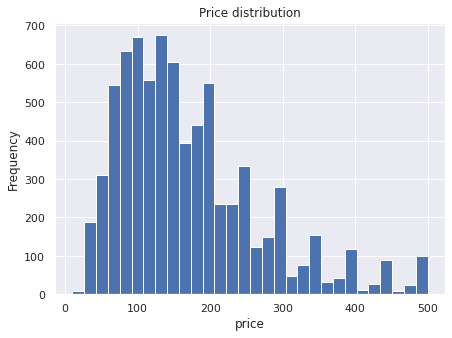

In [29]:
viz.hist(cleaned_df, 'price')

### 2.4 Minimum nights

Since there are a lot of outliers in the "minimum_nights" column, we need to see the best cut.

In [30]:
cleaned_df.minimum_nights.value_counts(normalize=True).reset_index().head(10)

,index,minimum_nights
0,30,0.419953
1,2,0.187647
2,1,0.176809
3,3,0.100548
4,4,0.034735
5,5,0.024549
6,31,0.014495
7,7,0.008880
8,32,0.007835
9,60,0.004962


In [31]:
# check the ratio between < 32 and > 32 days
pd.cut(rentals['minimum_nights'], bins=[0, 31, np.Inf]).value_counts(normalize=True)

(0.0, 31.0]    0.975589
(31.0, inf]    0.024411
Name: minimum_nights, dtype: float64

In [32]:
# check how many values were dropped
N = len(cleaned_df)

cleaned_df = cleaned_df[cleaned_df['minimum_nights'] < 32]

print(f'Before drop (min=1, max=1,000,000 days):     {N} rows')
print(f'After drop (min=1, max=31 days):             {len(cleaned_df)} rows')
print(f'Dropped:                                     {N - len(cleaned_df)} rows')

Before drop (min=1, max=1,000,000 days):     7658 rows
After drop (min=1, max=31 days):             7470 rows
Dropped:                                     188 rows


<AxesSubplot:>

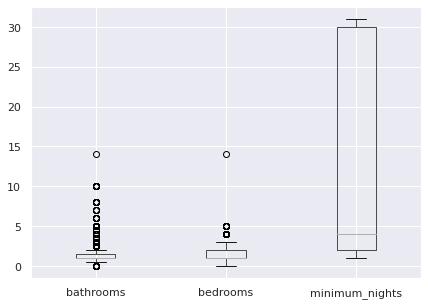

In [33]:
# check the boxplot 
cleaned_df.drop(['price', 'latitude', 'longitude'], axis='columns').boxplot()

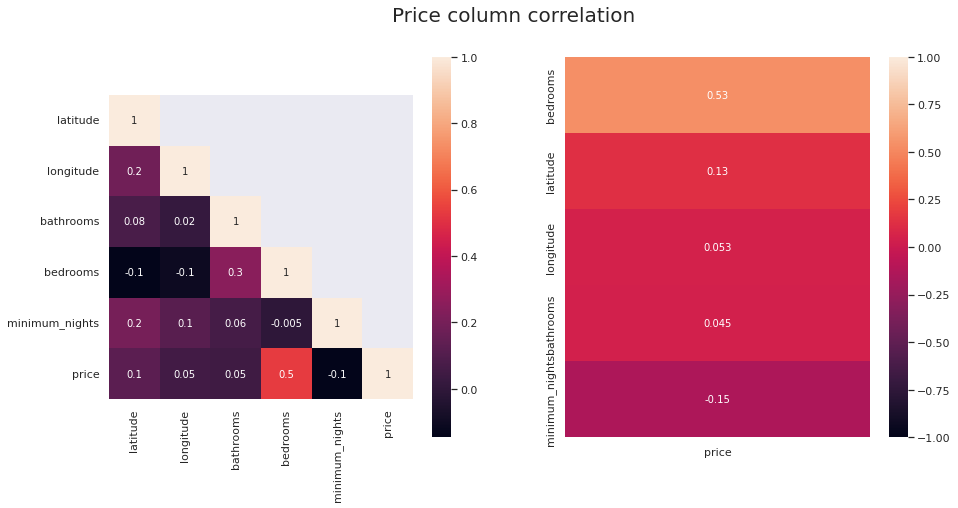

In [34]:
viz.corr_matrix(cleaned_df)

In [35]:
# current R2

quick_test.build_ols(cleaned_df, verbose=False)

R2: 0.59


### 2.5 Bedrooms 

- look into bedrooms with 0 rooms 
- look into bedrooms with > 2 rooms 


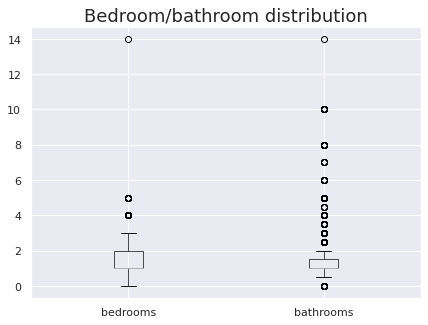

In [36]:
cleaned_df[['bedrooms', 'bathrooms']].boxplot()\
                                     .set_title('Bedroom/bathroom distribution', fontsize=18)
plt.show()

In [37]:
# bedrooms/bathrooms correlation
np.corrcoef(cleaned_df['bedrooms'], cleaned_df['bathrooms'])

array([[1.        , 0.25037669],
       [0.25037669, 1.        ]])

#### Zero bedroom

- Private, shared, and hotel rooms cannot have zero bedrooms, therefore we'll change the room number to 1.0
- Entire home/apt with zero rooms are studios, so we can leave them as is

# of instances: 836


Distribution of bedrooms in %
Entire home/apt    0.752392
Private room       0.206938
Hotel room         0.040670
Shared room        0.000000
Name: room_type, dtype: float64


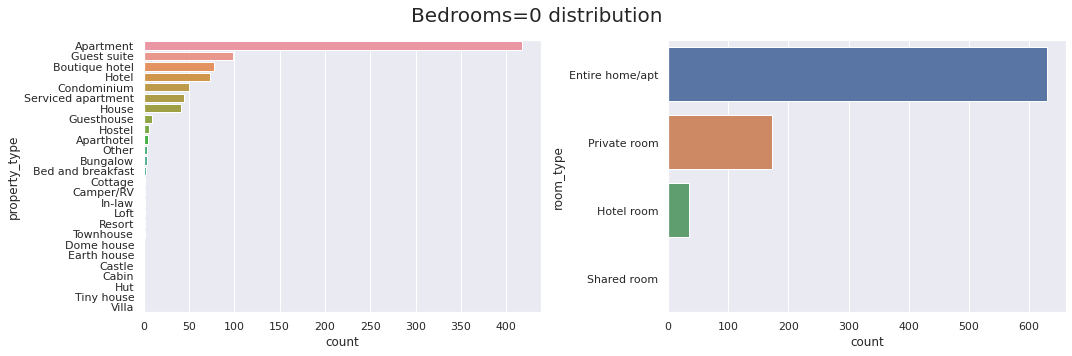

In [38]:
bedrooms = cleaned_df[cleaned_df['bedrooms'] == 0]

print(f'# of instances: {len(bedrooms)}')
print('\n\nDistribution of bedrooms in %')
print(bedrooms.room_type.value_counts(normalize=True))
 
viz.property_room(cleaned_df, col='bedrooms', val=0)

In [39]:
cleaned_df[(cleaned_df['property_type'] != 'Hotel') &
           (cleaned_df['room_type'] != 'Entire home/apt') &
           (cleaned_df['bedrooms'] == 0)]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
30,37.76212,-122.39541,House,Private room,1.0,0.0,4,125.0
285,37.80041,-122.41569,Serviced apartment,Hotel room,1.0,0.0,30,148.0
631,37.78729,-122.40944,Hostel,Private room,1.0,0.0,1,180.0
698,37.78712,-122.40960,Hostel,Private room,1.0,0.0,1,175.0
1065,37.78800,-122.41146,Hostel,Private room,1.0,0.0,1,180.0
...,...,...,...,...,...,...,...,...
7467,37.77799,-122.42086,Serviced apartment,Hotel room,1.0,0.0,2,99.0
7531,37.72602,-122.43988,House,Private room,1.0,0.0,30,92.0
7558,37.71868,-122.40844,House,Private room,1.0,0.0,1,65.0
7822,37.72510,-122.40433,House,Private room,1.0,0.0,30,70.0


In [40]:
idx = cleaned_df[(cleaned_df['room_type'] != 'Entire home/apt') &
                 (cleaned_df['bedrooms'] == 0)].index

cleaned_df.loc[idx, 'bedrooms'] = 1.0

In [41]:
idx = cleaned_df[(cleaned_df['property_type'] != 'Hotel') &
                 (cleaned_df['room_type'] != 'Entire home/apt') &
                 (cleaned_df['bedrooms'] > 1)].index

cleaned_df.loc[idx, 'bedrooms'] = 1.0

### 2.6 Bathrooms

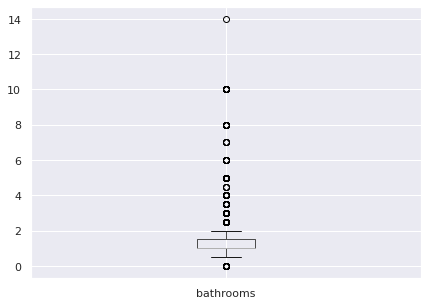

In [42]:
cleaned_df[['bathrooms']].boxplot()
plt.show()

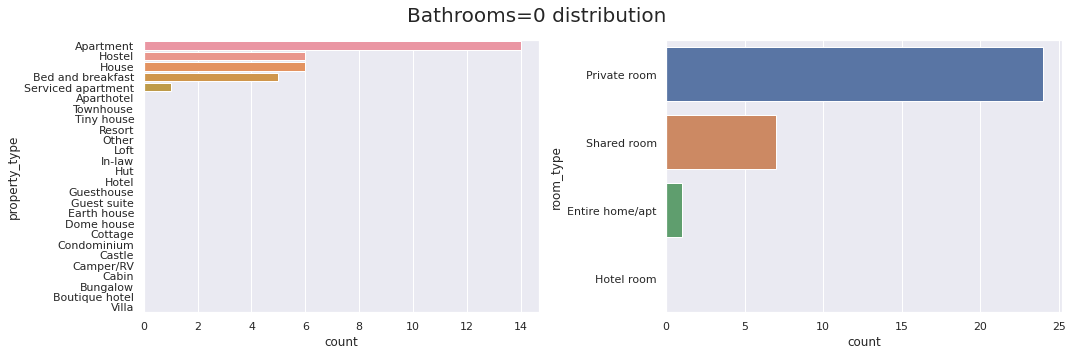

In [43]:
viz.property_room(cleaned_df, col='bathrooms', val=0)

In [44]:
cleaned_df.bathrooms.replace(0, 1, inplace=True)

In [45]:
idx = cleaned_df[cleaned_df['property_type'] == 'Bed and breakfast'].index
cleaned_df.loc[idx, 'bathrooms'] = 1.0

In [46]:
idx = cleaned_df[(cleaned_df['bathrooms'] > 1) & 
                 (cleaned_df['room_type'] != 'Entire home/apt')].index

cleaned_df.loc[idx, 'bathrooms'] = 1.0

In [47]:
cleaned_df.bathrooms.describe()

count    7470.000000
mean        1.153414
std         0.407650
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.500000
Name: bathrooms, dtype: float64

In [48]:
quick_test.build_ols(cleaned_df, verbose=False)

R2: 0.59


### 2.7 Property types

We see below that the first 5 property types make up 90% of the dataset. Logically, if these properties get cleaned, then the overall model has to do well. I have gone through each property and selected the thresholds already, and saved the new cleaned dataset which scores over 88% without any fancy models. Let's look at their predictions capabilities!

In [49]:
cleaned_df.property_type.value_counts(normalize=True).cumsum().head(10)

Apartment             0.408835
House                 0.690495
Condominium           0.795315
Guest suite           0.871754
Boutique hotel        0.905756
Hotel                 0.923159
Townhouse             0.939893
Serviced apartment    0.954217
Hostel                0.964525
Loft                  0.974431
Name: property_type, dtype: float64

In [50]:
properties = ['Apartment', 'House', 'Condominium', 'Guest suite', 'Boutique hotel']

# before drops 
for property_type in properties:
    temp = cleaned_df[cleaned_df['property_type'] == property_type]
    print(f'{property_type} accuracy score')
    quick_test.build_ols(temp, verbose=False)
    print('\n=====\n')

Apartment accuracy score
R2: 0.56

=====

House accuracy score
R2: 0.68

=====

Condominium accuracy score
R2: 0.52

=====

Guest suite accuracy score
R2: 0.36

=====

Boutique hotel accuracy score
R2: 0.28

=====



In [71]:
cleaned_df = pd.read_csv('data/cleaned_rentals.csv', index_col=0)
cleaned_df[['property_type', 'room_type']] = cleaned_df[['property_type', 'room_type']].astype('category')

# build an OLS model
quick_test.build_ols(cleaned_df, verbose=False)

R2: 0.88


In [52]:
# after drops
for property_type in properties:
    temp = cleaned_df[cleaned_df['property_type'] == property_type]
    print(f'{property_type} accuracy score')
    quick_test.build_ols(temp, verbose=False)
    print('\n=====\n')

Apartment accuracy score
R2: 0.91

=====

House accuracy score
R2: 0.89

=====

Condominium accuracy score
R2: 0.86

=====

Guest suite accuracy score
R2: 0.75

=====

Boutique hotel accuracy score
R2: 0.82

=====



In [53]:
predictions = predict.sample_predict(cleaned_df, n=20)
print('Mean prediction difference:', predictions['difference (actual - predicted)'].mean())
predictions

Mean prediction difference: -41.53099082692853


,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,predicted,difference (actual - predicted)
187,37.77023,-122.42957,Condominium,Private room,1.0,1.0,2,95.0,94.934701,0.065299
3668,37.73058,-122.43425,House,Entire home/apt,1.0,2.0,6,300.0,276.565154,23.434846
1306,37.76426,-122.46393,House,Private room,1.0,1.0,2,105.0,97.097582,7.902418
2724,37.78336,-122.43112,Apartment,Private room,1.0,1.0,30,60.0,86.770973,-26.770973
2326,37.73113,-122.38811,House,Private room,1.0,1.0,30,53.0,77.344262,-24.344262
4201,37.78784,-122.41623,House,Shared room,1.0,1.0,30,45.0,80.014600,-35.014600
1524,37.77653,-122.47387,House,Entire home/apt,1.5,2.0,30,195.0,274.196734,-79.196734
1694,37.78522,-122.40759,Aparthotel,Private room,1.0,1.0,1,70.0,145.785192,-75.785192
3383,37.77357,-122.41631,House,Shared room,1.0,1.0,30,40.0,77.509483,-37.509483
2797,37.76901,-122.42277,House,Private room,1.0,1.0,30,115.0,82.943389,32.056611


## 3.1 Feature selection

In [54]:
print('Current predictions accuracy')
quick_test.build_ols(cleaned_df, verbose=False)

Current predictions accuracy
R2: 0.88


In [59]:
X, y = cleaned_df.drop('price', axis='columns'), cleaned_df['price']
y = np.log1p(y)

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

estimator = SVR(kernel="linear")
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

array([ True, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False, False, False, False, False, False, False,
        True, False,  True,  True,  True])

In [63]:
mask = selector.support_
print('Columns to drop:')
X.columns[~mask].tolist()

Columns to drop:


['longitude',
 'property_type_Boutique hotel',
 'property_type_Cabin',
 'property_type_Castle',
 'property_type_Cottage',
 'property_type_Dome house',
 'property_type_Earth house',
 'property_type_Guesthouse',
 'property_type_Hut',
 'property_type_In-law',
 'property_type_Loft',
 'property_type_Other',
 'property_type_Resort',
 'property_type_Serviced apartment',
 'property_type_Tiny house',
 'property_type_Villa']

In [72]:
cleaned_df.drop('longitude', axis='columns', inplace=True)
cleaned_df = cleaned_df[~cleaned_df['property_type'].isin(
    ['Boutique hotel', 'Cabin', 'Castle', 'Cottage',
     'Dome house', 'Guesthouse', 'Hut', 'In-law', 'Loft',
     'Other', 'Resort', 'Serviced apartment', 'Tiny house', 'Villa'])]

In [73]:
cleaned_df.property_type.cat.remove_unused_categories(inplace=True)
cleaned_df.room_type.cat.remove_unused_categories(inplace=True)

quick_test.build_ols(cleaned_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1964.
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:40:05   Log-Likelihood:                 659.92
No. Observations:                4116   AIC:                            -1284.
Df Residuals:                    4098   BIC:                            -1170.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8926      0.003   1519.478      0.0

### 4. Build model

In [74]:
X, y = cleaned_df.drop('price', axis='columns'), cleaned_df['price']

y = np.log1p(y)
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scale = StandardScaler()

X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

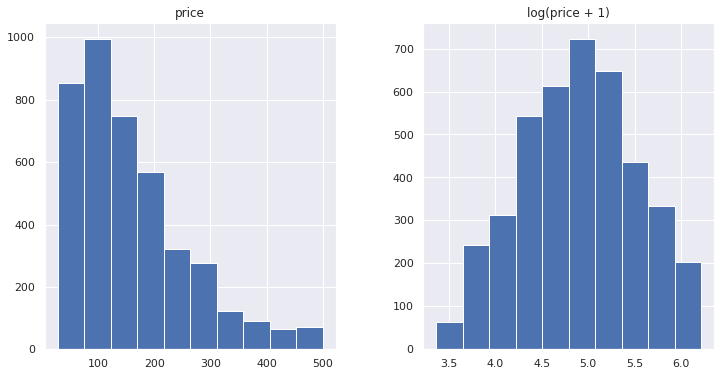

In [75]:
# plot unnormalized and normalized price columns
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price': cleaned_df['price'], 
                       'log(price + 1)': np.log1p(cleaned_df['price'])})
prices.hist()
plt.show()

In [76]:
# temp = cleaned_df.copy()
target = cleaned_df.price
target = np.log1p(cleaned_df['price'])

cleaned_df.drop('price', axis='columns', inplace=True)
skewed_features = cleaned_df.select_dtypes(include=np.number).apply(lambda x: skew(x))
skewed_features

latitude         -0.330223
bathrooms         2.751428
bedrooms          1.485076
minimum_nights    0.154602
dtype: float64

In [77]:
skewed_features = skewed_features[skewed_features > 0.75].index
cleaned_df[skewed_features] = np.log1p(cleaned_df[skewed_features])

In [78]:
cleaned_df = pd.get_dummies(cleaned_df)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df, target, test_size=0.25)


In [82]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [83]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0, 0.5, 'rmse')

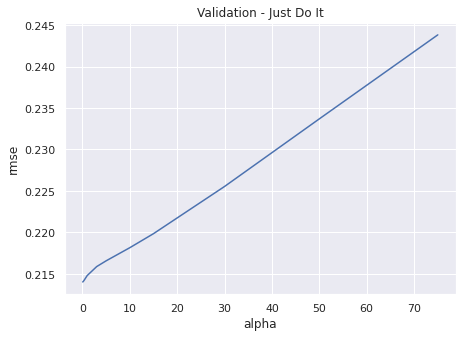

In [84]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [85]:


cv_ridge.min()



0.21402767545252996

In [86]:


model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

rmse_cv(model_lasso).mean()

0.21600637895288757

In [87]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [88]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 17 variables and eliminated the other 2 variables


In [89]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

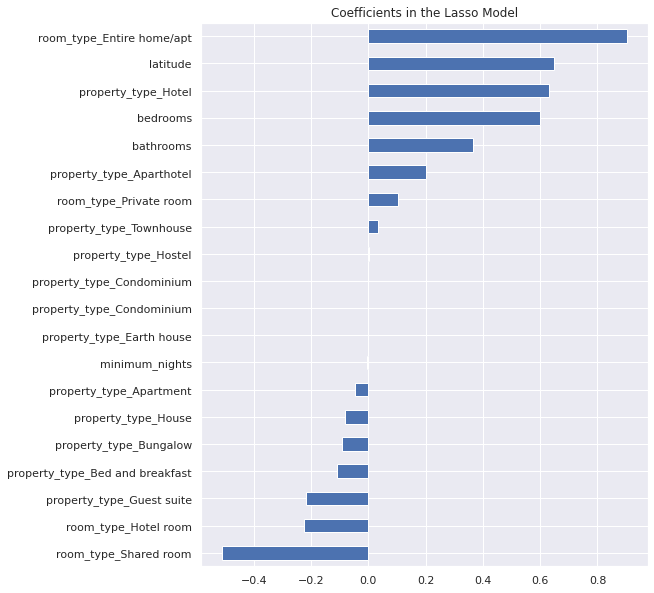

In [90]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='preds', ylabel='residuals'>

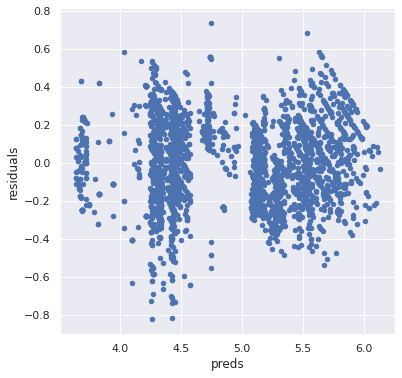

In [91]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


In [92]:
model_xgb = xgb.XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.1) 
model_xgb.fit(X_train, y_train)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [93]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='xgb', ylabel='lasso'>

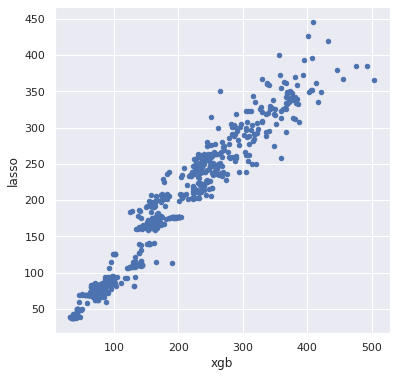

In [94]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [95]:
predictions['actual'] = np.expm1(y_test)

In [96]:
predictions

,xgb,lasso,actual
0,166.507385,181.402956,170.0
1,145.797791,165.425486,99.0
2,65.010551,72.684807,235.0
3,273.604553,227.731204,225.0
4,79.421600,73.954240,120.0
...,...,...,...
1024,247.844940,243.302461,NaN
1025,82.248268,81.925384,NaN
1026,142.951050,164.708631,95.0
1027,157.546616,162.602594,NaN


In [97]:
model_xgb.score(X_test, y_test)

0.9010845721218782

In [98]:
sample = temp.sample(n=10)
sample

,latitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
3935,37.74232,House,Private room,1.0,1.0,30,70.0
2490,37.79103,Apartment,Entire home/apt,1.0,1.0,30,181.0
3821,37.76068,Apartment,Private room,1.0,1.0,3,110.0
3688,37.77338,Condominium,Entire home/apt,1.0,2.0,2,250.0
2269,37.75805,Apartment,Entire home/apt,1.0,1.0,4,160.0
164,37.76197,Apartment,Entire home/apt,1.0,1.0,30,170.0
4095,37.75868,Apartment,Entire home/apt,1.0,1.0,30,157.0
1458,37.75958,House,Entire home/apt,1.5,2.0,3,348.0
3661,37.78712,Condominium,Entire home/apt,1.5,1.0,2,145.0
2561,37.74041,House,Entire home/apt,1.0,2.0,3,350.0


In [103]:
X_sample = sample.drop('price', axis='columns')
X_sample = pd.get_dummies(X_sample)

In [104]:
np.expm1(model_xgb.predict(X_sample))

array([ 71.38083, 232.60783,  97.93333, 526.14044, 284.23126, 237.69916,
       237.79933, 402.28973, 325.40808, 457.3699 ], dtype=float32)

In [105]:
sample['predicted'] = np.expm1(model_xgb.predict(X_sample))

In [106]:
sample['difference'] = sample['price'] - sample['predicted']

In [107]:
sample

,latitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,predicted,difference
3935,37.74232,House,Private room,1.0,1.0,30,70.0,71.380829,-1.380829
2490,37.79103,Apartment,Entire home/apt,1.0,1.0,30,181.0,232.607834,-51.607834
3821,37.76068,Apartment,Private room,1.0,1.0,3,110.0,97.933327,12.066673
3688,37.77338,Condominium,Entire home/apt,1.0,2.0,2,250.0,526.140442,-276.140442
2269,37.75805,Apartment,Entire home/apt,1.0,1.0,4,160.0,284.231262,-124.231262
164,37.76197,Apartment,Entire home/apt,1.0,1.0,30,170.0,237.699158,-67.699158
4095,37.75868,Apartment,Entire home/apt,1.0,1.0,30,157.0,237.799332,-80.799332
1458,37.75958,House,Entire home/apt,1.5,2.0,3,348.0,402.289734,-54.289734
3661,37.78712,Condominium,Entire home/apt,1.5,1.0,2,145.0,325.408081,-180.408081
2561,37.74041,House,Entire home/apt,1.0,2.0,3,350.0,457.369904,-107.369904
